<center>

# [Компьютерное зрение](http://rairi.ru/wiki/index.php/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5)

## <center> Семинар 11 - Трекинг

<a target="_blank" href="https://colab.research.google.com/github/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_11/Seminar_11.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

***

In [10]:
# !pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
# !pip install ultralytics filterpy lap
# !pip uninstall -y numpy protobuf
# !pip install -U numpy==1.23.5 protobuf==3.20.3

In [11]:
from typing import Tuple
from time import time
import types
from pathlib import Path

from scipy.optimize import linear_sum_assignment
import numpy as np
import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO

# Вспомогательные функции

In [12]:
def show_image(img: np.ndarray) -> None:
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def detection_visualization(
    img_path: Path, preds: np.ndarray
) -> np.ndarray:
    img = cv2.imread(str(img_path)) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(preds)):
        cv2.rectangle(
            img,
            (int(preds[i][0]), int(preds[i][1])),
            (int(preds[i][2]), int(preds[i][3])),
            color=(0, 255, 0),
            thickness=3,
        )
    return img


def tracking_visualization(
    img_path: Path, preds: np.ndarray
) -> np.ndarray:
    img = cv2.imread(str(img_path)) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(preds)):
        cv2.rectangle(
            img,
            (int(preds[i][0]), int(preds[i][1])),
            (int(preds[i][2]), int(preds[i][3])),
            color=(0, 255, 0),
            thickness=3,
        )
        cv2.putText(
            img,
            str(int(preds[i][4])),
            (int(preds[i][0]), int(preds[i][1])),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=2,
            color=(0, 255, 0),
            thickness=3
        )
    return img


# Датасет

В рамках данного семинара мы будем использовать трек `MOT17-09` из датасета MOT Challenge https://motchallenge.net/

Ссылка на скачивание датасета https://motchallenge.net/data/MOT17Det/ 

In [13]:
dataset_dir = Path("/home/melekhin_aa/Datasets/MOT17_09_imgs")  # путь к директории с изображениями трека MOT17-09
frames_list = sorted([f for f in dataset_dir.iterdir()])

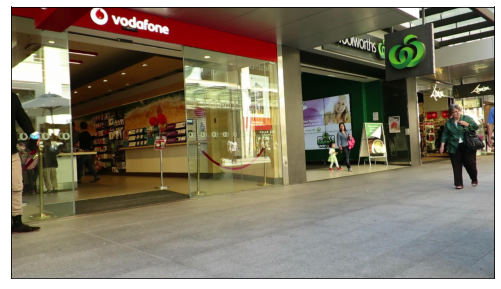

In [14]:
img = cv2.cvtColor(cv2.imread(str(frames_list[0])), cv2.COLOR_BGR2RGB)
show_image(img)

# Детекция с помощью YOLOv8

В качестве бэкбона детекции мы будем использовать YOLOv8s из библиотеки ultralytics: https://github.com/ultralytics/ultralytics

In [15]:
class YoloDetector:
    def __init__(self, conf_threshold: float = 0.5) -> None:
        self.backbone = YOLO("yolov8s.pt")
        self.conf_threshold = conf_threshold
    
    def __call__(self, img_path: Path) -> np.ndarray:
        preds = self.backbone.predict(source=img_path, conf=self.conf_threshold, show=False, classes=0)
        preds = preds[0].boxes.data.cpu().numpy()[:, :5]
        return preds


image 1/1 /home/melekhin_aa/Datasets/MOT17_09_imgs/000001.jpg: 384x640 7 persons, 6.5ms
Speed: 0.4ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


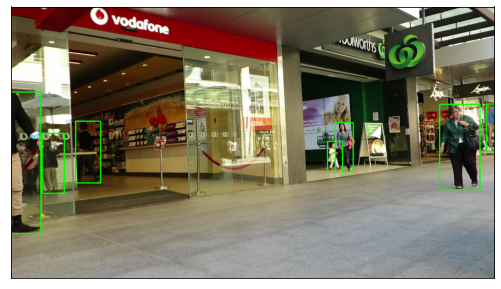

In [16]:
detector = YoloDetector()
preds = detector(frames_list[0])

out_frame = detection_visualization(frames_list[0], preds)
show_image(out_frame)

# Алгоритм трекинга SORT

SORT: https://arxiv.org/abs/1602.00763

Разделы "3.3. Data Association" и "3.4. Creation and Deletion of Track Identities" описывают алгоритм соотнесения результатов детекции последовательных кадров:

> **3.3. Data Association**
> 
> In assigning detections to existing targets, each target’s
> bounding box geometry is estimated by predicting its new
> location in the current frame. The assignment cost matrix is
> then computed as the intersection-over-union (IOU) distance
> between each detection and all predicted bounding boxes
> from the existing targets. The assignment is solved optimally
> using the Hungarian algorithm. Additionally, a minimum
> IOU is imposed to reject assignments where the detection to
> target overlap is less than $IOU_{min}$.
>
> We found that the IOU distance of the bounding boxes
> implicitly handles short term occlusion caused by passing targets.
> Specifically, when a target is covered by an occluding
> object, only the occluder is detected, since the IOU distance
> appropriately favours detections with similar scale. This allows
> both the occluder target to be corrected with the detection while 
> the covered target is unaffected as no assignment is made.

> **3.4. Creation and Deletion of Track Identities**
>
> When objects enter and leave the image, unique identities
> need to be created or destroyed accordingly. For creating
> trackers, we consider any detection with an overlap less than
> $IOU_{min}$ to signify the existence of an untracked object. The
> tracker is initialised using the geometry of the bounding box
> with the velocity set to zero. Since the velocity is unobserved
> at this point the covariance of the velocity component is initialised
> with large values, reflecting this uncertainty. Additionally, the new
> tracker then undergoes a probationary period where the target needs
> to be associated with detections to accumulate enough evidence in order
> to prevent tracking of false positives.
> 
> Tracks are terminated if they are not detected for $T_{Lost}$
> frames. This prevents an unbounded growth in the number
> of trackers and localisation errors caused by predictions over
> long durations without corrections from the detector. In all
> experiments $T_{Lost}$ is set to 1 for two reasons. Firstly, the constant
> velocity model is a poor predictor of the true dynamics
> and secondly we are primarily concerned with frame-to-frame
> tracking where object re-identification is beyond the scope of
> this work. Additionally, early deletion of lost targets aids efficiency.
> Should an object reappear, tracking will implicitly resume under a new identity.

# Венгерский алгоритм (Hungarian algorithm)

- [Wikipedia](https://en.wikipedia.org/wiki/Hungarian_algorithm)
- Реализация в библиотеке scipy: [`scipy.optimize.linear_sum_assignment`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html)
- Реализация в библиотеке [lap](https://github.com/gatagat/lap): `lap.lapjv` 

## Задание 1:

Реализуйте Венгерский алгоритм. Сравните возвращаемые значения с библиотечной функцией [`scipy.optimize.linear_sum_assignment`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html).

In [17]:
def hungarian_algorithm(cost_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Solves the assignment problem using the Hungarian algorithm.

    Args:
        cost_matrix (np.ndarray): Numpy array of shape (n, m) representing the cost matrix.

    Returns:
        A tuple of two numpy arrays (row_ind, col_ind) representing the row and column indices
        of the assigned cells in the cost matrix.
    """
    pass


In [ ]:
cost_matrix = np.array([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]])
my_row_ind, my_col_ind = hungarian_algorithm(cost_matrix)
my_cost = cost_matrix[my_row_ind, my_col_ind].sum()
row_ind, col_ind = linear_sum_assignment(cost_matrix)
cost = cost_matrix[row_ind, col_ind].sum()

assert my_cost == cost

# Алгоритм трекинга ByteTrack

- Статья https://arxiv.org/abs/2110.06864
- Код https://github.com/ifzhang/ByteTrack


## Вопрос 1:

В чем заключается ключевая особенность метода BYTE?

**Ответ:**

In [ ]:
# !git clone https://github.com/ifzhang/ByteTrack.git
# %cd ByteTrack
# !pip install -r requirements.txt
# !python setup.py develop
# %cd ..
# !pip install cython
# !pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# !pip install cython_bbox

In [19]:
from yolox.tracker.byte_tracker import BYTETracker

fps = 30
frame_size = (1080, 1920)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_file = 'output.mp4'
video_writer = cv2.VideoWriter(output_file, fourcc, fps, frame_size[::-1])

args = types.SimpleNamespace(**{
    "track_thresh": 0.5,
    "track_buffer": 30,
    "match_thresh": 0.8,
    "mot20": False,

})
tracker = BYTETracker(args, frame_rate=fps)

det_times = []
track_times = []

for frame_path in frames_list:
    s_time = time()
    detections = detector(frame_path)
    det_times.append((time() - s_time) * 1000)  # in ms
    s_time = time()
    tracks = tracker.update(detections, frame_size, frame_size)
    track_times.append((time() - s_time) * 1000)  # in ms
    tracks = [t.tlbr.tolist() + [t.track_id] for t in tracks]
    out_frame = tracking_visualization(frame_path, tracks)
    video_writer.write(cv2.cvtColor(out_frame, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(f"./output/{str(frame_path.name)}", cv2.cvtColor(out_frame, cv2.COLOR_RGB2BGR))
video_writer.release()

print(f"mean detection time: {np.mean(det_times)}, mean track time: {np.mean(track_times)}")


image 1/1 /home/melekhin_aa/Datasets/MOT17_09_imgs/000001.jpg: 384x640 7 persons, 5.9ms
Speed: 2.6ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/melekhin_aa/Datasets/MOT17_09_imgs/000002.jpg: 384x640 7 persons, 5.9ms
Speed: 0.4ms preprocess, 5.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/melekhin_aa/Datasets/MOT17_09_imgs/000003.jpg: 384x640 7 persons, 5.9ms
Speed: 0.4ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/melekhin_aa/Datasets/MOT17_09_imgs/000004.jpg: 384x640 7 persons, 6.0ms
Speed: 0.4ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/melekhin_aa/Datasets/MOT17_09_imgs/000005.jpg: 384x640 7 persons, 6.4ms
Speed: 0.4ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/melekhin_aa/Datasets/MOT17_09_imgs/000006.jpg: 384x640 7 p

mean detection time: 28.48913556053525, mean track time: 1.2960388546898252


## Задание 2

Объедините BYTE и любой трекер с Re-ID признаками (например, FairMOT). Можно воспользоваться инструкциями из репозитория: https://github.com/ifzhang/ByteTrack/tree/main/tutorials

Ответом на это задание должен быть код, записывающий видео работы метода для трека MOT17-09 в файл `reid_out.mp4`. Убедитесь, что код работает "end-to-end". 